In [1]:
# https://towardsdatascience.com/choosing-the-correct-error-metric-mape-vs-smape-5328dec53fac
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# def mape(y_true, y_pred):
#     return mean_absolute_error(y_true, y_pred) * 100


# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_percentage_error.html
# https://stackoverflow.com/questions/47648133/mape-calculation-in-python
def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mape(y_true, y_pred): 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100

# https://stackoverflow.com/questions/49604269/run-all-regressors-against-the-data-in-scikit
def evaluate_model(mas, model, X_train, y_train, X_test, y_test, model_name, if_plot):
    # fit the model
    model.fit(X_train, y_train)

    # predict the values using training data
    train_pred = model.predict(X_train)

    # evaluate using training data
    train_rmse = rmse(y_train, train_pred)
#     train_mae = mean_absolute_error(y_train, train_pred)
    train_mape = mape(y_train, train_pred)
    train_r2 = r2_score(y_train, train_pred)
    
    # print the results of the training data
    print("---Training data results---\n")
    print("Root Mean Squared Error: {:.2f}\n".format(train_rmse))
    print("R Square: {:.2f}\n".format(train_r2))
#     print("Mean Absolute Error: {:.2f}\n".format(train_mae))
    print("Mean Absolute Percentage Error: {:.2f}\n".format(train_mape))
    
    # predict the values using testing data
    test_pred = model.predict(X_test)

    # evaluate using testing data
    test_rmse = rmse(y_test, test_pred)
#     test_mae = mean_absolute_error(y_test, test_pred)
    test_mape = mape(y_test, test_pred)
    test_r2 = r2_score(y_test, test_pred)
    
        # print the results of the testing data
    print("-----Testing data results-----\n")
    print("Root Mean Squared Error: {:.2f}\n".format(test_rmse))
    print("R Square: {:.2f}\n".format(test_r2))
#     print("Mean Absolute Error: {:.2f}\n".format(test_mae))
    print("Mean Absolute Percentage Error: {:.2f}\n".format(test_mape))
    
    if if_plot=="Yes":
        plot_model(mas, y_train,y_test,train_pred,test_pred,model_name)
    else:
        print("No plot")
        
    tree_explained=['EXTR','Gradient Boosting','Random Forest','Light GBM','Xgboost','Catboost']
    
    if model_name in tree_explained:
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_train)
        shap.summary_plot(shap_values, X_train, plot_type='bar')
        shap.summary_plot(shap_values, X_train)

        shap.initjs()

#         for i in range(len(X_test)):
#             display(shap.force_plot(explainer.expected_value, shap_values[i], features=X_train.loc[i], 
#             feature_names=X_train.columns))
            
    return train_rmse, train_mape, train_r2, test_rmse, test_mape, test_r2

# https://stackoverflow.com/questions/48973140/how-to-interpret-mse-in-keras-regressor/49009442#49009442


def plot_model(mas, y_train, y_test, train_pred, test_pred, model_name):
    # Inverse transform predictions and target values
    train_pred = mas.inverse_transform(train_pred.reshape(-1, 1)).ravel()
    y_train = mas.inverse_transform(y_train.reshape(-1, 1)).ravel()
    test_pred = mas.inverse_transform(test_pred.reshape(-1, 1)).ravel()
    y_test = mas.inverse_transform(y_test.reshape(-1, 1)).ravel()

    # Create a DataFrame for the data
    data = {
        'Time': list(range(len(y_train) + len(y_test))),
        'Values': list(y_train) + list(y_test),
        'Type': ['Actual Train Data'] * len(y_train) + ['Actual Test Data'] * len(y_test),
        'Predictions': list(train_pred) + list(test_pred),
        'Model': [str(model_name) + ' Train Predictions'] * len(y_train) + [str(model_name) + ' Test Predictions'] * len(y_test)
    }

    df = pd.DataFrame(data)

    # Plot using Plotly Express
    fig = px.line(df, x='Time', y='Values', color='Type', labels={'Values': 'Values'},
                  title=str(model_name) + ' - Train and Test Data vs. Predictions')

    fig.add_scatter(x=df[df['Type'] == 'Actual Train Data']['Time'], y=df[df['Type'] == 'Actual Train Data']['Predictions'],
                    mode='lines', line=dict(color='red'), name=str(model_name) + ' Train Predictions')

    fig.add_scatter(x=df[df['Type'] == 'Actual Test Data']['Time'], y=df[df['Type'] == 'Actual Test Data']['Predictions'],
                    mode='lines', line=dict(color='orange'), name=str(model_name) + ' Test Predictions')

    # Show the plot
    fig.update_layout(xaxis_title='Time/Iterations', yaxis_title='Values', legend_title='Legend')
    fig.show()
    

def feature_importance(model, X_train, model_name):
    features = X_train.columns
    importances = model.feature_importances_
    indices = np.argsort(importances)

    # customized number 
    num_features = 25

    plt.figure(figsize=(10,10))
    plt.title('Feature Importances')

    # only plot the customized number of features
    plt.barh(range(num_features), importances[indices[-num_features:]], color='r', align='center')
    plt.yticks(range(num_features), [features[i] for i in indices[-num_features:]])
    plt.xlabel(str(model_name)+'s Feature Importance')
    plt.show();

In [2]:
## Important
# https://datascience.stackexchange.com/questions/51323/how-to-interpret-metrics-of-a-model-after-scaling-the-data
# https://www.quora.com/When-is-it-necessary-to-normalize-time-series-data-for-predictive-analysis-and-when-is-it-not

## Importing Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import StandardScaler,MinMaxScaler,MaxAbsScaler

from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score


from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import ExtraTreeRegressor
from sklearn.svm import SVR
from sklearn.svm import NuSVR
from sklearn.svm import LinearSVR

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

import time
import shap

pd.options.mode.chained_assignment = None

import warnings
warnings.filterwarnings("ignore")

In [5]:
timed_df=pd.read_excel("InvoiceData_concate_cleaned_grouped_flu_stock_weekly.xlsx")
# timed_df.drop('Date', axis = 1,inplace=True)

In [6]:
timed_df

,reference_date,customer_name_top_Customer 1,customer_name_top_Customer 2,customer_name_top_Customer 3,customer_name_top_Customer 4,customer_name_top_Customer 5,customer_name_top_Customer 6,customer_name_top_Customer 7,customer_name_top_Customer 8,day_Friday,...,Volume_HELX,Volume_IHI,Volume_XLV,Close_HELX,Close_IHI,Close_XLV,Volume_DHR,Volume_TMO,Close_DHR,Close_TMO
0,2020-12-28,1,0,4,0,2,2,1,0,10,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2021-01-04,269,162,651,135,155,143,254,5,256,...,15.166667,4.844308,4.924573,5.268076,5.121616,5.101993,5.281879,4.839443,5.248175,5.187106
2,2021-01-11,308,144,630,116,52,102,236,14,310,...,16.000000,19.492188,2.868756,5.559773,5.171015,5.180700,3.659546,3.800261,5.367111,5.328049
3,2021-01-18,256,226,579,111,37,134,206,27,282,...,21.833333,7.587054,2.632809,5.725794,5.194018,5.213370,3.757839,3.764727,5.290732,5.411640
4,2021-01-25,289,299,644,172,65,151,190,11,208,...,26.722222,5.302455,3.767980,5.469415,5.140734,5.149713,5.278497,4.155422,5.199749,5.331101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,2023-07-31,356,70,716,208,110,105,150,22,192,...,1.277778,4.435826,4.543038,3.483506,5.138399,6.129355,4.356084,3.272564,5.793910,5.850718
136,2023-08-07,421,79,770,220,144,133,178,13,270,...,1.500000,5.422340,3.703318,3.445455,4.991897,6.202016,2.430290,2.152765,5.809344,5.852700
137,2023-08-14,321,93,698,186,95,169,160,28,205,...,0.277778,3.797898,3.712186,3.398299,4.893918,6.191991,2.743586,2.384435,5.745437,5.694502
138,2023-08-21,358,96,691,160,91,82,159,41,224,...,0.666667,3.473214,3.085503,3.395135,4.817961,6.128528,2.664933,2.571429,5.720046,5.720438


In [7]:
train=timed_df[timed_df['reference_date']<'2023-05-01']

In [8]:
test=timed_df[timed_df['reference_date']>='2023-05-01']

In [9]:
timed_df.head()

,reference_date,customer_name_top_Customer 1,customer_name_top_Customer 2,customer_name_top_Customer 3,customer_name_top_Customer 4,customer_name_top_Customer 5,customer_name_top_Customer 6,customer_name_top_Customer 7,customer_name_top_Customer 8,day_Friday,...,Volume_HELX,Volume_IHI,Volume_XLV,Close_HELX,Close_IHI,Close_XLV,Volume_DHR,Volume_TMO,Close_DHR,Close_TMO
0,2020-12-28,1,0,4,0,2,2,1,0,10,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2021-01-04,269,162,651,135,155,143,254,5,256,...,15.166667,4.844308,4.924573,5.268076,5.121616,5.101993,5.281879,4.839443,5.248175,5.187106
2,2021-01-11,308,144,630,116,52,102,236,14,310,...,16.000000,19.492188,2.868756,5.559773,5.171015,5.180700,3.659546,3.800261,5.367111,5.328049
3,2021-01-18,256,226,579,111,37,134,206,27,282,...,21.833333,7.587054,2.632809,5.725794,5.194018,5.213370,3.757839,3.764727,5.290732,5.411640
4,2021-01-25,289,299,644,172,65,151,190,11,208,...,26.722222,5.302455,3.767980,5.469415,5.140734,5.149713,5.278497,4.155422,5.199749,5.331101


In [10]:
train.drop('reference_date', axis = 1,inplace=True)
test.drop('reference_date', axis = 1,inplace=True)

In [11]:
# https://datascience.stackexchange.com/questions/38395/standardscaler-before-or-after-splitting-data-which-is-better

In [12]:
mas_features= MaxAbsScaler()

train_array_features = mas_features.fit_transform(train.drop('amount_p$_sum', axis = 1))
test_array_features = mas_features.transform(test.drop('amount_p$_sum', axis = 1))

train_features = pd.DataFrame(train_array_features,columns = train.drop('amount_p$_sum', axis = 1).columns)
test_features = pd.DataFrame(test_array_features,columns = test.drop('amount_p$_sum', axis = 1).columns)


In [13]:
X_train = train_features
X_test = test_features

mas_outcome= MaxAbsScaler()

y_train = mas_outcome.fit_transform(train['amount_p$_sum'].values.reshape(-1, 1))
y_test = mas_outcome.transform(test['amount_p$_sum'].values.reshape(-1, 1))


# y_train = train['amount_p$_sum']
# y_test = test['amount_p$_sum']

In [14]:
# https://discuss.python.org/t/comparison-table-for-rmse-and-mae-using-three-different-models/24946

In [15]:
base_models = [
    ('Linear Regression',LinearRegression()),
    ('Stochastic Gradient Descent Regression',SGDRegressor()),
    ('Decision Tree Regression',DecisionTreeRegressor()),
    ('Extra Tree Regressor',ExtraTreeRegressor()),
    ('Support Vector Regression',SVR()),
    ('Nu Support Vector Regression',NuSVR()),
    ('Linear Support Vector Regression',LinearSVR()),
    ('K-Nearest Neighbors',KNeighborsRegressor()),
    ('Multi Layer Perceptron',MLPRegressor()),
    ('Extra Trees Regressor',ExtraTreesRegressor()),
    ('Bagging Regressor',BaggingRegressor()),
    ('Gradient Boosting',GradientBoostingRegressor()),
    ('Adaboost Regressor',AdaBoostRegressor()),
    ('Random Forest Regressor',RandomForestRegressor()),
    ('Light GBM Regressor',LGBMRegressor()),
    ('Xgboost',XGBRegressor()),
    ('Catboost',CatBoostRegressor()),
]


----------------------------------------------------Model: Linear Regression
---Training data results---

Root Mean Squared Error: 0.07

R Square: 0.70

Mean Absolute Percentage Error: 135.59

-----Testing data results-----

Root Mean Squared Error: 0.12

R Square: -0.30

Mean Absolute Percentage Error: 29.18



----------------------------------

----------------------------------------------------Model: Stochastic Gradient Descent Regression
---Training data results---

Root Mean Squared Error: 0.12

R Square: 0.24

Mean Absolute Percentage Error: 113.64

-----Testing data results-----

Root Mean Squared Error: 0.08

R Square: 0.38

Mean Absolute Percentage Error: 20.69



----------------------------------

----------------------------------------------------Model: Decision Tree Regression
---Training data results---

Root Mean Squared Error: 0.00

R Square: 1.00

Mean Absolute Percentage Error: 0.00

-----Testing data results-----

Root Mean Squared Error: 0.18

R Square: -2.10

Mean Absolute Percentage Error: 41.92



----------------------------------

----------------------------------------------------Model: Extra Tree Regressor
---Training data results---

Root Mean Squared Error: 0.00

R Square: 1.00

Mean Absolute Percentage Error: 0.00

-----Testing data results-----

Root Mean Squared Error: 0.13

R Square: -0.54

Mean Absolute Percentage Error: 23.68



----------------------------------

----------------------------------------------------Model: Support Vector Regression
---Training data results---

Root Mean Squared Error: 0.08

R Square: 0.65

Mean Absolute Percentage Error: 470.02

-----Testing data results-----

Root Mean Squared Error: 0.10

R Square: 0.04

Mean Absolute Percentage Error: 29.06



----------------------------------

----------------------------------------------------Model: Nu Support Vector Regression
---Training data results---

Root Mean Squared Error: 0.04

R Square: 0.89

Mean Absolute Percentage Error: 4.53

-----Testing data results-----

Root Mean Squared Error: 0.10

R Square: 0.02

Mean Absolute Percentage Error: 25.83



----------------------------------

----------------------------------------------------Model: Linear Support Vector Regression
---Training data results---

Root Mean Squared Error: 0.09

R Square: 0.58

Mean Absolute Percentage Error: 15.68

-----Testing data results-----

Root Mean Squared Error: 0.13

R Square: -0.60

Mean Absolute Percentage Error: 30.73



----------------------------------

----------------------------------------------------Model: K-Nearest Neighbors
---Training data results---

Root Mean Squared Error: 0.11

R Square: 0.26

Mean Absolute Percentage Error: 983.06

-----Testing data results-----

Root Mean Squared Error: 0.10

R Square: -0.04

Mean Absolute Percentage Error: 30.77



----------------------------------

----------------------------------------------------Model: Multi Layer Perceptron
---Training data results---

Root Mean Squared Error: 0.09

R Square: 0.57

Mean Absolute Percentage Error: 710.38

-----Testing data results-----

Root Mean Squared Error: 0.12

R Square: -0.51

Mean Absolute Percentage Error: 32.44



----------------------------------

----------------------------------------------------Model: Extra Trees Regressor
---Training data results---

Root Mean Squared Error: 0.00

R Square: 1.00

Mean Absolute Percentage Error: 0.00

-----Testing data results-----

Root Mean Squared Error: 0.08

R Square: 0.38

Mean Absolute Percentage Error: 22.42



----------------------------------

----------------------------------------------------Model: Bagging Regressor
---Training data results---

Root Mean Squared Error: 0.05

R Square: 0.85

Mean Absolute Percentage Error: 413.42

-----Testing data results-----

Root Mean Squared Error: 0.08

R Square: 0.34

Mean Absolute Percentage Error: 22.92



----------------------------------

----------------------------------------------------Model: Gradient Boosting
---Training data results---

Root Mean Squared Error: 0.01

R Square: 0.99

Mean Absolute Percentage Error: 16.71

-----Testing data results-----

Root Mean Squared Error: 0.07

R Square: 0.55

Mean Absolute Percentage Error: 19.31



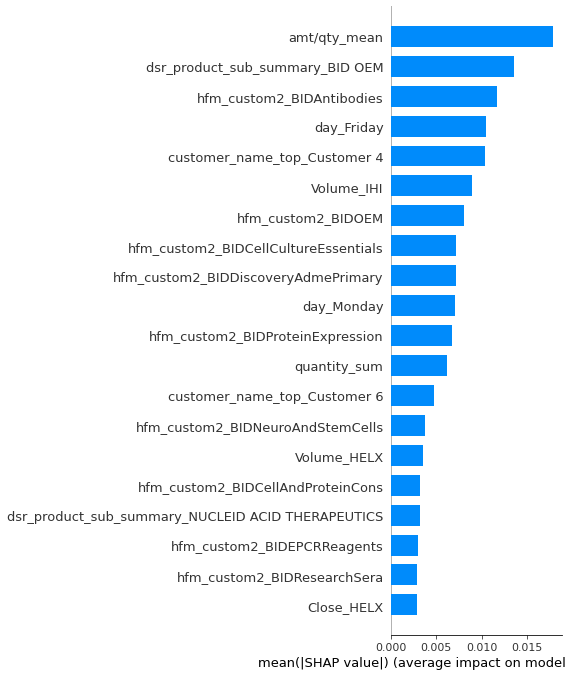

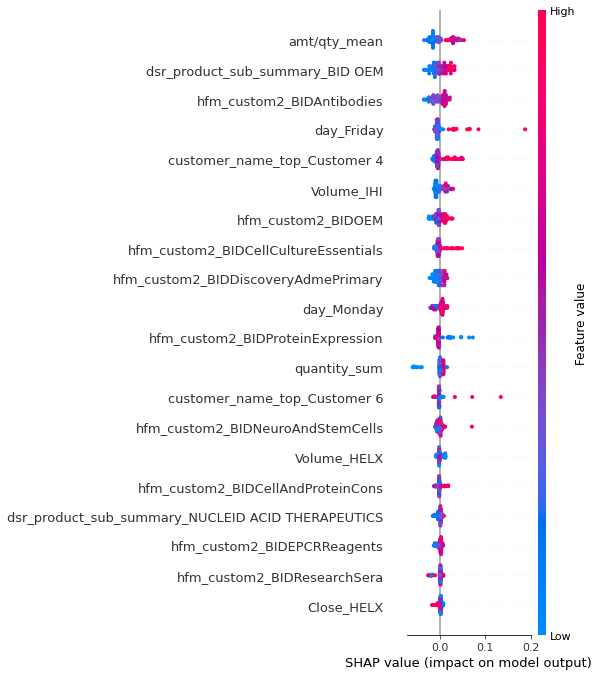

----------------------------------

----------------------------------------------------Model: Adaboost Regressor
---Training data results---

Root Mean Squared Error: 0.06

R Square: 0.79

Mean Absolute Percentage Error: 480.29

-----Testing data results-----

Root Mean Squared Error: 0.08

R Square: 0.38

Mean Absolute Percentage Error: 22.76



----------------------------------

----------------------------------------------------Model: Random Forest Regressor
---Training data results---

Root Mean Squared Error: 0.05

R Square: 0.87

Mean Absolute Percentage Error: 490.93

-----Testing data results-----

Root Mean Squared Error: 0.08

R Square: 0.35

Mean Absolute Percentage Error: 22.73



----------------------------------

----------------------------------------------------Model: Light GBM Regressor
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000362 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2101
[LightGBM] [Info] Number of data points in the train set: 122, number of used features: 67
[LightGBM] [Info] Start training from score 0.345122
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

----------------------------------

----------------------------------------------------Model: Xgboost
---Training data results---

Root Mean Squared Error: 0.00

R Square: 1.00

Mean Absolute Percentage Error: 4.67

-----Testing data results-----

Root Mean Squared Error: 0.07

R Square: 0.46

Mean Absolute Percentage Error: 19.42



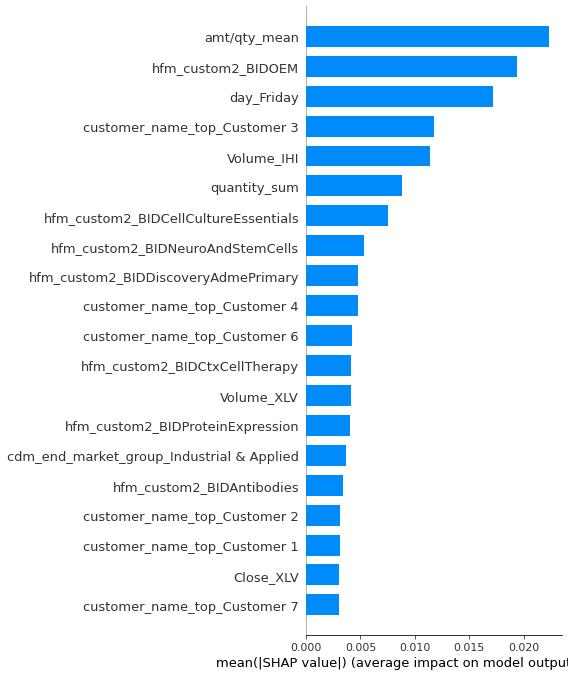

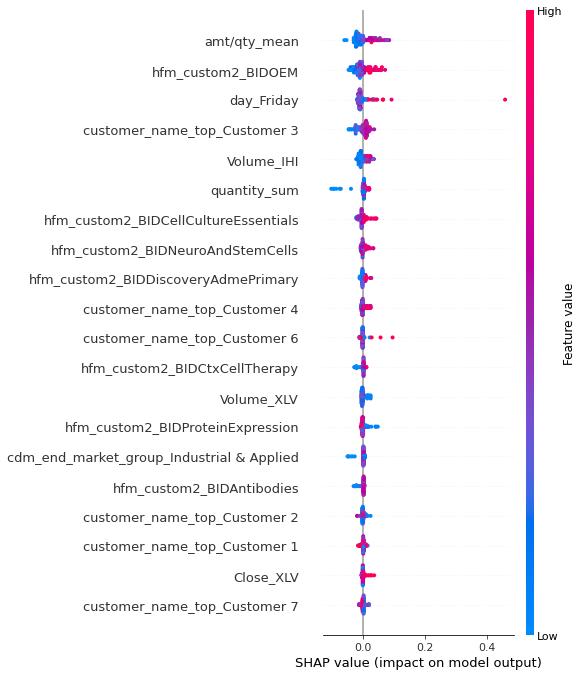

----------------------------------

----------------------------------------------------Model: Catboost
Learning rate set to 0.029365
0:	learn: 0.1328725	total: 3.03ms	remaining: 3.03s
1:	learn: 0.1321333	total: 5.72ms	remaining: 2.85s
2:	learn: 0.1311892	total: 8.5ms	remaining: 2.82s
3:	learn: 0.1304632	total: 11ms	remaining: 2.75s
4:	learn: 0.1296152	total: 13.5ms	remaining: 2.69s
5:	learn: 0.1289845	total: 16.2ms	remaining: 2.69s
6:	learn: 0.1283316	total: 19.2ms	remaining: 2.72s
7:	learn: 0.1273610	total: 21.9ms	remaining: 2.72s
8:	learn: 0.1268537	total: 24.9ms	remaining: 2.74s
9:	learn: 0.1259693	total: 28.3ms	remaining: 2.8s
10:	learn: 0.1252586	total: 32.5ms	remaining: 2.92s
11:	learn: 0.1246915	total: 35.9ms	remaining: 2.96s
12:	learn: 0.1239200	total: 39.2ms	remaining: 2.98s
13:	learn: 0.1234780	total: 42.7ms	remaining: 3.01s
14:	learn: 0.1229429	total: 47.4ms	remaining: 3.11s
15:	learn: 0.1222443	total: 51.9ms	remaining: 3.19s
16:	learn: 0.1219606	total: 55.7ms	remaining: 3.

170:	learn: 0.0621521	total: 701ms	remaining: 3.4s
171:	learn: 0.0619046	total: 706ms	remaining: 3.4s
172:	learn: 0.0616057	total: 710ms	remaining: 3.39s
173:	learn: 0.0614535	total: 714ms	remaining: 3.39s
174:	learn: 0.0612277	total: 719ms	remaining: 3.39s
175:	learn: 0.0607044	total: 723ms	remaining: 3.38s
176:	learn: 0.0605675	total: 727ms	remaining: 3.38s
177:	learn: 0.0603834	total: 732ms	remaining: 3.38s
178:	learn: 0.0601921	total: 736ms	remaining: 3.37s
179:	learn: 0.0598959	total: 740ms	remaining: 3.37s
180:	learn: 0.0594957	total: 744ms	remaining: 3.37s
181:	learn: 0.0591090	total: 749ms	remaining: 3.36s
182:	learn: 0.0587044	total: 752ms	remaining: 3.36s
183:	learn: 0.0582829	total: 756ms	remaining: 3.35s
184:	learn: 0.0579355	total: 760ms	remaining: 3.35s
185:	learn: 0.0575579	total: 764ms	remaining: 3.34s
186:	learn: 0.0571402	total: 768ms	remaining: 3.34s
187:	learn: 0.0568389	total: 771ms	remaining: 3.33s
188:	learn: 0.0565155	total: 775ms	remaining: 3.33s
189:	learn: 0.

366:	learn: 0.0209779	total: 1.49s	remaining: 2.57s
367:	learn: 0.0208044	total: 1.49s	remaining: 2.56s
368:	learn: 0.0207412	total: 1.5s	remaining: 2.56s
369:	learn: 0.0205913	total: 1.5s	remaining: 2.56s
370:	learn: 0.0204364	total: 1.51s	remaining: 2.55s
371:	learn: 0.0202969	total: 1.51s	remaining: 2.55s
372:	learn: 0.0201293	total: 1.51s	remaining: 2.55s
373:	learn: 0.0199807	total: 1.52s	remaining: 2.54s
374:	learn: 0.0197942	total: 1.52s	remaining: 2.54s
375:	learn: 0.0197729	total: 1.53s	remaining: 2.54s
376:	learn: 0.0196102	total: 1.53s	remaining: 2.53s
377:	learn: 0.0195145	total: 1.54s	remaining: 2.53s
378:	learn: 0.0194275	total: 1.54s	remaining: 2.53s
379:	learn: 0.0192978	total: 1.54s	remaining: 2.52s
380:	learn: 0.0192794	total: 1.55s	remaining: 2.52s
381:	learn: 0.0191561	total: 1.55s	remaining: 2.52s
382:	learn: 0.0190577	total: 1.56s	remaining: 2.51s
383:	learn: 0.0188889	total: 1.56s	remaining: 2.51s
384:	learn: 0.0187228	total: 1.57s	remaining: 2.5s
385:	learn: 0.0

538:	learn: 0.0078840	total: 2.28s	remaining: 1.95s
539:	learn: 0.0078533	total: 2.28s	remaining: 1.95s
540:	learn: 0.0078137	total: 2.29s	remaining: 1.94s
541:	learn: 0.0077574	total: 2.29s	remaining: 1.94s
542:	learn: 0.0076909	total: 2.3s	remaining: 1.94s
543:	learn: 0.0076594	total: 2.3s	remaining: 1.93s
544:	learn: 0.0076089	total: 2.31s	remaining: 1.93s
545:	learn: 0.0075914	total: 2.31s	remaining: 1.92s
546:	learn: 0.0075742	total: 2.32s	remaining: 1.92s
547:	learn: 0.0075186	total: 2.33s	remaining: 1.92s
548:	learn: 0.0074924	total: 2.33s	remaining: 1.92s
549:	learn: 0.0074752	total: 2.34s	remaining: 1.91s
550:	learn: 0.0074371	total: 2.34s	remaining: 1.91s
551:	learn: 0.0073808	total: 2.35s	remaining: 1.91s
552:	learn: 0.0073300	total: 2.35s	remaining: 1.9s
553:	learn: 0.0072627	total: 2.36s	remaining: 1.9s
554:	learn: 0.0072350	total: 2.37s	remaining: 1.9s
555:	learn: 0.0071698	total: 2.37s	remaining: 1.89s
556:	learn: 0.0071468	total: 2.38s	remaining: 1.89s
557:	learn: 0.007

705:	learn: 0.0028587	total: 3.11s	remaining: 1.29s
706:	learn: 0.0028359	total: 3.11s	remaining: 1.29s
707:	learn: 0.0028269	total: 3.12s	remaining: 1.29s
708:	learn: 0.0028066	total: 3.13s	remaining: 1.28s
709:	learn: 0.0027850	total: 3.13s	remaining: 1.28s
710:	learn: 0.0027637	total: 3.13s	remaining: 1.27s
711:	learn: 0.0027515	total: 3.14s	remaining: 1.27s
712:	learn: 0.0027292	total: 3.15s	remaining: 1.27s
713:	learn: 0.0027138	total: 3.15s	remaining: 1.26s
714:	learn: 0.0026945	total: 3.16s	remaining: 1.26s
715:	learn: 0.0026752	total: 3.16s	remaining: 1.25s
716:	learn: 0.0026657	total: 3.17s	remaining: 1.25s
717:	learn: 0.0026506	total: 3.17s	remaining: 1.25s
718:	learn: 0.0026442	total: 3.18s	remaining: 1.24s
719:	learn: 0.0026420	total: 3.18s	remaining: 1.24s
720:	learn: 0.0026273	total: 3.19s	remaining: 1.23s
721:	learn: 0.0026063	total: 3.19s	remaining: 1.23s
722:	learn: 0.0025911	total: 3.2s	remaining: 1.23s
723:	learn: 0.0025742	total: 3.21s	remaining: 1.22s
724:	learn: 0

874:	learn: 0.0010701	total: 3.88s	remaining: 555ms
875:	learn: 0.0010667	total: 3.89s	remaining: 551ms
876:	learn: 0.0010605	total: 3.89s	remaining: 546ms
877:	learn: 0.0010538	total: 3.9s	remaining: 542ms
878:	learn: 0.0010469	total: 3.9s	remaining: 537ms
879:	learn: 0.0010380	total: 3.91s	remaining: 533ms
880:	learn: 0.0010355	total: 3.91s	remaining: 528ms
881:	learn: 0.0010270	total: 3.92s	remaining: 524ms
882:	learn: 0.0010175	total: 3.92s	remaining: 520ms
883:	learn: 0.0010089	total: 3.93s	remaining: 515ms
884:	learn: 0.0010007	total: 3.93s	remaining: 511ms
885:	learn: 0.0009967	total: 3.94s	remaining: 506ms
886:	learn: 0.0009889	total: 3.94s	remaining: 502ms
887:	learn: 0.0009875	total: 3.94s	remaining: 498ms
888:	learn: 0.0009800	total: 3.95s	remaining: 493ms
889:	learn: 0.0009746	total: 3.95s	remaining: 489ms
890:	learn: 0.0009714	total: 3.96s	remaining: 484ms
891:	learn: 0.0009689	total: 3.96s	remaining: 480ms
892:	learn: 0.0009646	total: 3.96s	remaining: 475ms
893:	learn: 0.

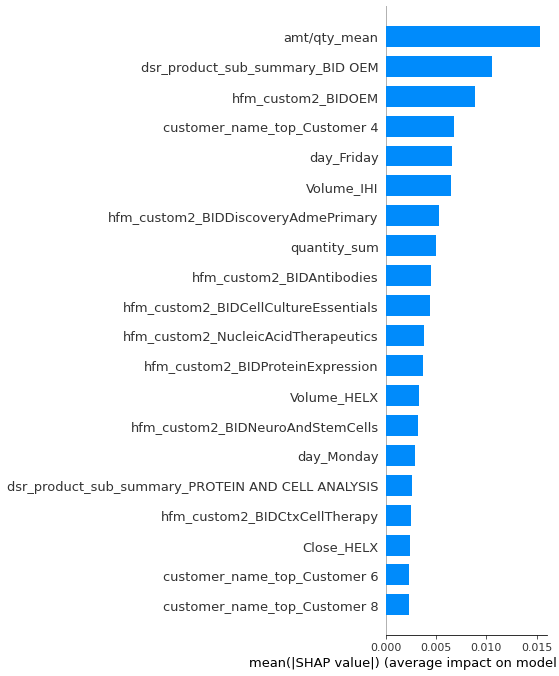

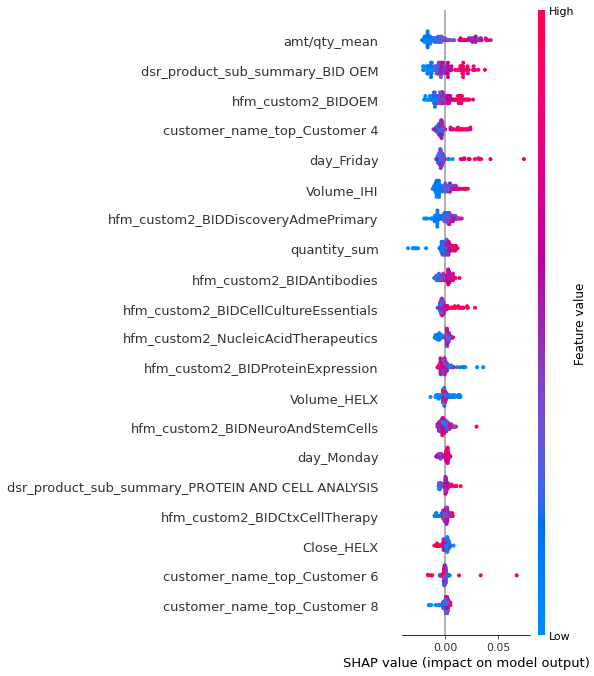

----------------------------------



In [24]:
train_rmse_l, train_mape_l, train_r2_l, test_rmse_l, test_mape_l, test_r2_l, model_name_l =\
[], [], [], [], [], [], []

for name, model_n in base_models:
#     start_time = time.time()
    print("---------------------------------------------------- Model: {}".format(name))
    train_rmse, train_mape, train_r2, test_rmse, test_mape, test_r2=\
    evaluate_model(mas_outcome, model_n, X_train, y_train, X_test, y_test,name,if_plot="Yes")
    train_rmse_l.append(train_rmse)
    train_mape_l.append(train_mape)
    train_r2_l.append(train_r2)
    test_rmse_l.append(test_rmse)
    test_mape_l.append(test_mape)
    test_r2_l.append(test_r2)
    model_name_l.append(name)
#     end_time = time.time()
#     print("Computation Time: {}".format(end_time - start_time))
    print("----------------------------------\n")
    

In [17]:
modelval_data = {
    "Model Name": model_name_l,
    "Train RMSE": train_rmse_l,
    "Test RMSE": test_rmse_l,
    "Train MAE": train_mae_l,
    "Test MAE": test_mae_l,
    "Train MAPE": train_mape_l,
    "Test MAPE": test_mape_l,
    "Train R2": train_r2_l,    
    "Test R2": test_r2_l,
}
model_metric_df = pd.DataFrame(modelval_data)

NameError: name 'train_mae_l' is not defined

## Weekly

In [ ]:
model_metric_df['diff'] = (model_metric_df['Train MAPE'] - model_metric_df['Test MAPE']).abs()

In [ ]:
# model_metric_df.style.background_gradient(cmap='Reds')
model_metric_df[['Model Name','Train MAPE','Test MAPE','diff']]\
                .sort_values(['diff','Test MAPE','Train MAPE'],ascending=True).style.background_gradient(cmap='Reds')

In [ ]:
# model_metric_df.style.background_gradient(cmap='Reds')
# model_metric_df[['Model Name','Train MAPE','Test MAPE']].style.background_gradient(cmap='Reds')

In [ ]:
# model_metric_df['diff'] = (model_metric_df['Train MAPE'] - model_metric_df['Test MAPE']).abs()

In [ ]:
model_metric_df[['Model Name','Train MAPE','Test MAPE','diff']].sort_values(['diff'],ascending=True)

In [ ]:
model_metric_df.sort_values(['diff'],ascending=True)[:5]['Model Name']

In [ ]:
specific_stack_model_list=model_metric_df.sort_values(['diff'],ascending=True)[:5]['Model Name']
specific_stack_model = \
[(model_name, model) for model_name, model in base_models if model_name in specific_stack_model_list.tolist()]
specific_stack_model

### Stacking Regressor

In [ ]:
from sklearn.ensemble import StackingRegressor
stacked = StackingRegressor(
    estimators = specific_stack_model,
    final_estimator = LinearRegression(),
    cv = 5)
start_time = time.time()
evaluate_model(mas_outcome,stacked, X_train, y_train, X_test, y_test,"Stacked_regressor",if_plot="Yes")
end_time = time.time()
print("Computation Time: {}".format(end_time - start_time))
print("----------------------------------\n")

### Stacking Regressor Mlextend

In [ ]:
specific_stack_model_extend = \
[(model) for model_name, model in base_models if model_name in specific_stack_model_list.tolist()]
specific_stack_model_extend

In [ ]:
from mlxtend.regressor import StackingRegressor as StackingRegressor_mlextend


In [ ]:
stregr = StackingRegressor_mlextend(regressors=specific_stack_model_extend, 
                           meta_regressor=GradientBoostingRegressor())
start_time = time.time()
evaluate_model(mas_outcome,stregr, X_train, y_train, X_test, y_test,"Stacked_regressor_mlextend",if_plot="Yes")
end_time = time.time()
print("Computation Time: {}".format(end_time - start_time))
print("----------------------------------\n")


### Voting Regressor

In [ ]:
from sklearn.ensemble import VotingRegressor

In [ ]:
vtregr = VotingRegressor(estimators=specific_stack_model,n_jobs=-1)
start_time = time.time()
evaluate_model(mas_outcome,vtregr, X_train, y_train, X_test, y_test,"Voting_Regressor",if_plot="Yes")
end_time = time.time()
print("Computation Time: {}".format(end_time - start_time))
print("----------------------------------\n")
